### **Package installations**

In [92]:
###########Download necessary libraries###########
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# from causalml.inference.meta import LRSRegressor, XGBTRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor, BaseSRegressor
# from causalml.propensity import ElasticNetPropensityModel
# from causalml.inference.tf import DragonNet
# from causalml.metrics import get_cumgain, plot_gain, *
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib
import missingno as msno
from sklearn import preprocessing
from yellowbrick.model_selection import LearningCurve
from sklearn import ensemble, model_selection, preprocessing, tree
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [93]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Artur\OneDrive\Documentos\GitHub\Superstore-Marketing-Campaign\superstore_data.csv")
number_of_rows = len(data)
# Display basic information
print (number_of_rows)
print(data.info())
print(data.describe())

2240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-nul

In [94]:
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


#### **Data exploration**

In [95]:
##########Desciptive statistics##################
data.describe()

,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000


In [96]:
###########Check data dictionary###########
data_description = pd.read_excel("datadictionary.xlsx").dropna()

data_description.style.set_properties(subset=["Description"], **{"width":"200px"})

,Column Name,Data Type,Description
0,ID,int64,Unique ID of each customer
1,Year_Birth,int64,Age of the customer
2,Complain,int64,1 if the customer complained in the last 2 years
3,Dt_Customer,object,Date of customer's enrollment with the company
4,Education,object,Customer's level of education
5,Marital_Status,object,Customer's marital status
6,Kidhome,int64,Number of small children in customer's household
7,Teenhome,int64,Number of teenagers in customer's household
8,Income,float64,Customer's yearly household income
9,MntFishProducts,int64,The amount spent on fish products in the last 2 years


#### **Dealing with missing values**

In [97]:
###########Null values handling and analysis###########
# Function to calculate missing values by column for a dataframe
def missing_values(df: pd.DataFrame) -> pd.DataFrame:
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print(
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    return mis_val_table_ren_columns


In [98]:
# Missing values statistics
miss_values = missing_values(data)

miss_values.head(20)

Dataframe has 22 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Income,24,1.1


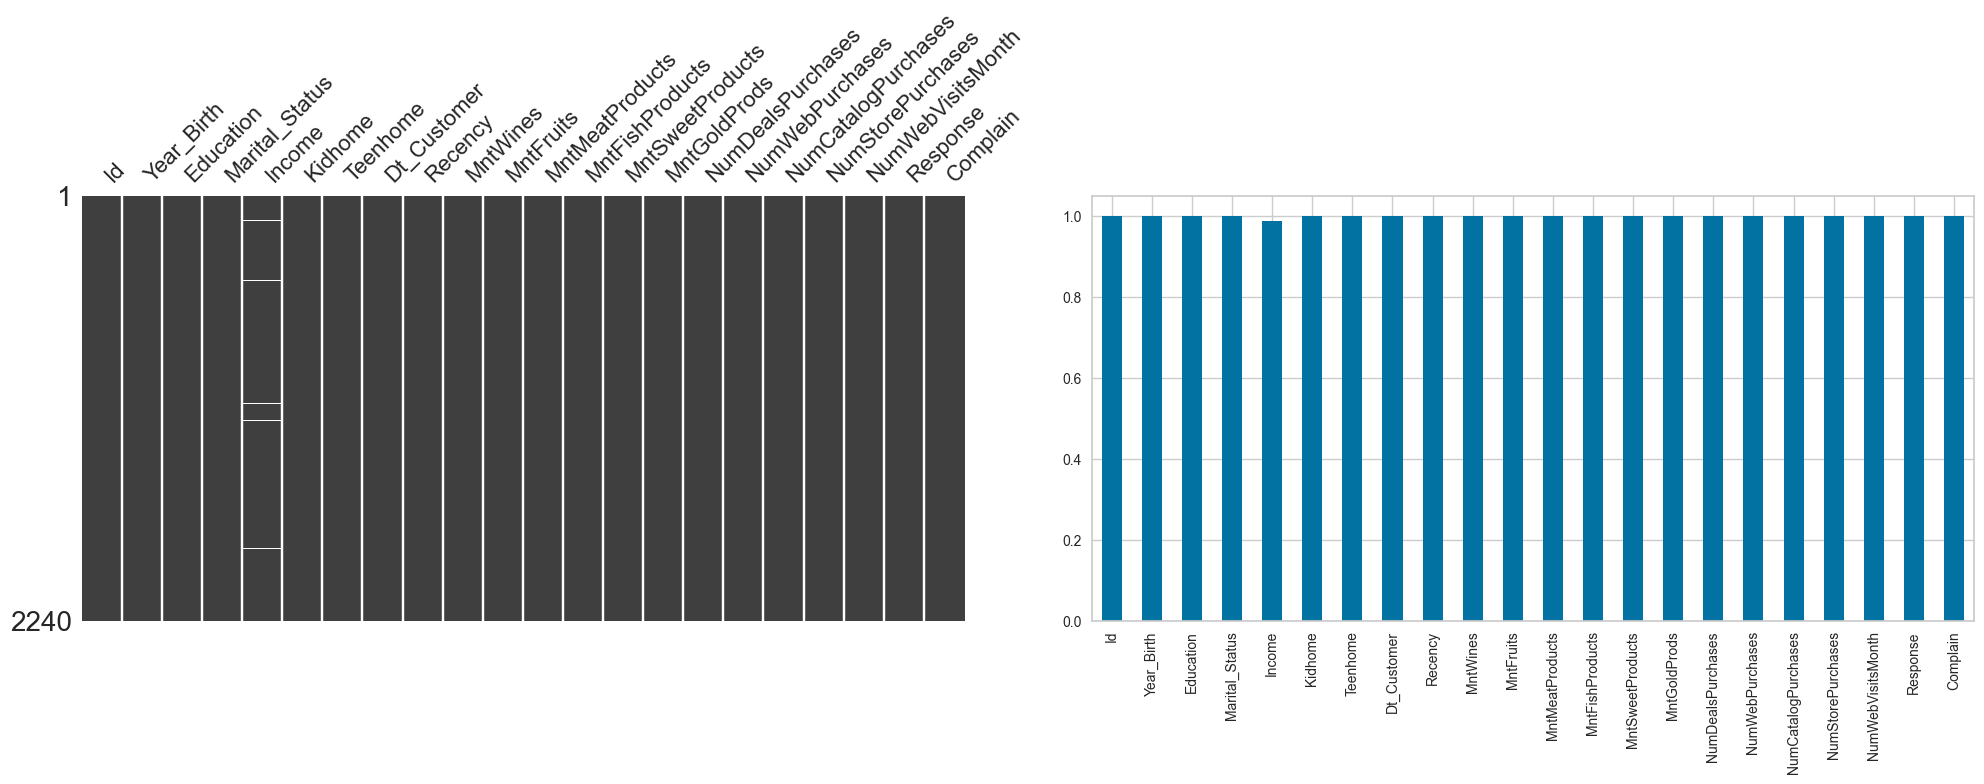

In [99]:
#######Visualizing missing values#########
# Create figure and subplots for side by side display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# First plot - missingness matrix
msno.matrix(data, ax=ax1)
# Second plot - bar plot
(1 - data.isnull().mean()).abs().plot.bar(ax=ax2)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [100]:
# Correlation heatmap to ensure if  there's any relationship among missingness 
#ax = msno.heatmap(data, figsize=(18, 18)) there's just one columns this would bear no insights

In [101]:
#Dendogram
#ax = msno.dendrogram(data)

In [102]:
#Looking at the characteristics of the missing values
missing_income = data[data['Income'].isnull()]
print("Profile of customers with missing income:")
print(missing_income.describe())
## There are some noteworthy patterns in the data mainly that the
## size of the househol tend to be high, with one kid and one teen at home
## also these missing income does not respond well to the offer 4% only

Profile of customers with missing income:
                 Id   Year_Birth  Income    Kidhome   Teenhome    Recency  \
count     24.000000    24.000000     0.0  24.000000  24.000000  24.000000   
mean    5943.625000  1967.458333     NaN   0.666667   0.583333  58.041667   
std     3028.349268    12.021644     NaN   0.637022   0.583592  29.492046   
min     1295.000000  1943.000000     NaN   0.000000   0.000000   4.000000   
25%     3063.250000  1957.750000     NaN   0.000000   0.000000  35.500000   
50%     5526.500000  1969.500000     NaN   1.000000   1.000000  62.000000   
75%     8597.750000  1974.250000     NaN   1.000000   1.000000  82.250000   
max    10629.000000  1989.000000     NaN   2.000000   2.000000  96.000000   

         MntWines   MntFruits  MntMeatProducts  MntFishProducts  \
count   24.000000   24.000000        24.000000        24.000000   
mean   197.208333   21.333333       162.708333        27.166667   
std    242.479758   38.310705       339.420411        41.281290

In [103]:
## Since we have few data points missing and relatively low variation
## in household size and purchase pattern we decide to input based on median 
## and create a new column to indicate if it's been imputed or not

## since there only 24 missing values we could consider also drop them 
def add_indicator(col: str) -> callable:
    """
    Creates a function that adds an indicator column to a DataFrame.

    This function returns a wrapper function that, when applied to a DataFrame,
    generates a new Series indicating the presence of missing values in the specified column.
    The resulting Series contains 1 for missing values and 0 for non-missing values.

    Parameters:
    col (str): The name of the column to check for missing values.

    Returns:
    callable: A function that takes a DataFrame and returns a Series with indicators for missing values.
    """

    def wrapper(df: pd.DataFrame) -> pd.Series:
        return df[col].isna().astype(int)

    return wrapper


In [104]:
data1 = data.assign(income_missing = add_indicator("Income"))

#### **Drop and imputation of missing values** 

In [105]:
### If a column has more than 70% of its rows missing we remove the column
temp = [i for i in data.count() < len(data) * 0.30]

data.drop(data.columns[temp], axis=1, inplace=True)

In [106]:
# Impute missing values with the median
data["Income"] = data["Income"].fillna(
    data["Income"].median()
)

#### **Target variable**

In [107]:
data["Response"].unique()

array([1, 0], dtype=int64)

#### **Data exploration 2**

In [108]:
###########Identify and separate type of columns###########
# Change Dt_Customer to datetime type for a better visualization 
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

# Identify numeric columns
numeric_col_names = data.select_dtypes(include=['number']).columns.tolist()

# Separate numeric columns into binary vs non-binary
binary_cols = []
numeric_cols = []
for col in numeric_col_names:
    unique_vals = data[col].dropna().unique()
    if len(unique_vals) == 2:
        binary_cols.append(col)
    else:
        numeric_cols.append(col)

# Identify datetime columns
datetime_cols = data.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Identify categorical columns (everything else)
all_non_numeric = [col for col in data.columns if col not in numeric_col_names]
categorical_cols = [col for col in all_non_numeric if col not in datetime_cols]

# Print the results
print("Binary columns:", binary_cols)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("Datetime columns:", datetime_cols)

Binary columns: ['Response', 'Complain']
Numeric columns: ['Id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Categorical columns: ['Education', 'Marital_Status']
Datetime columns: ['Dt_Customer']


Text(0, 0.5, 'Data type')

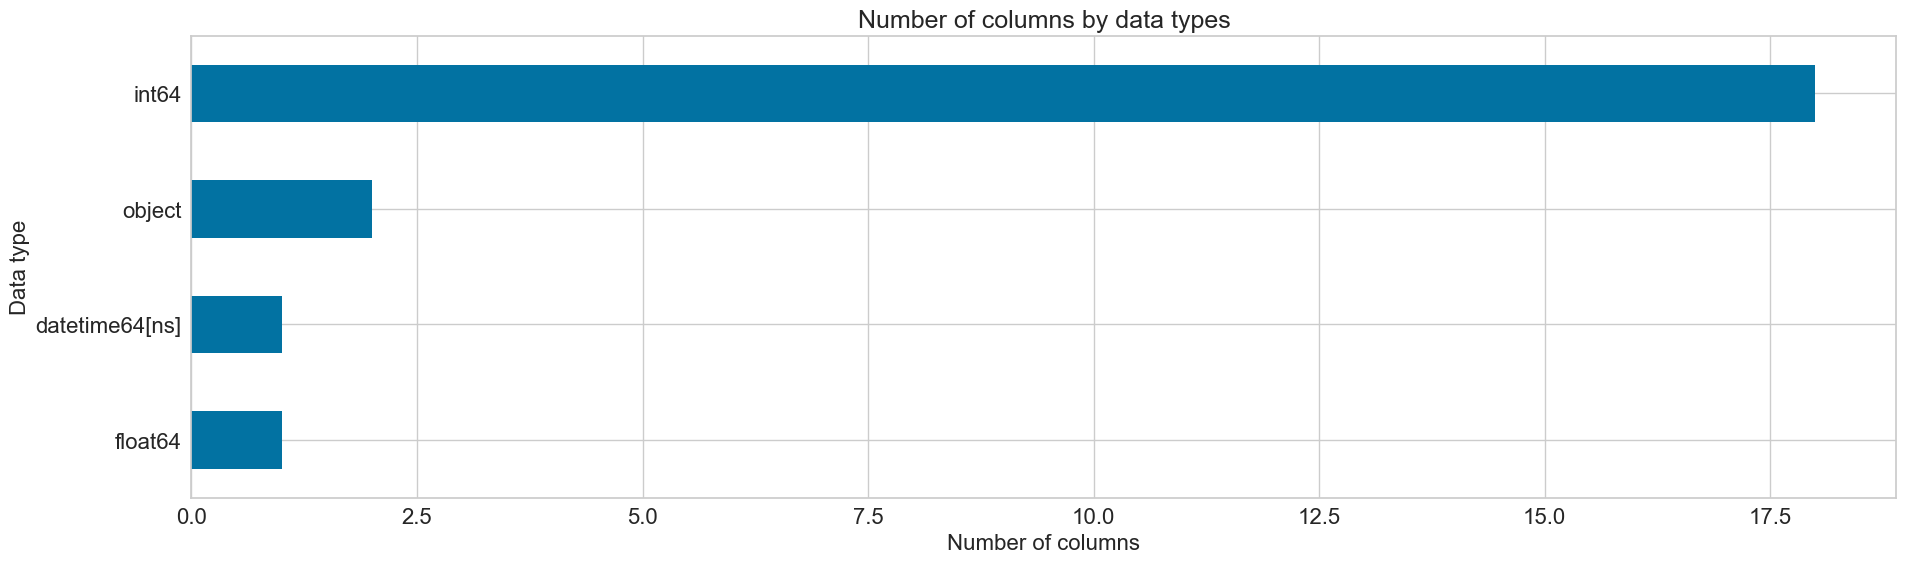

In [109]:
# Number of each type of column
data.dtypes.value_counts().sort_values().plot(kind="barh", figsize=(22, 6), fontsize=16)

plt.title("Number of columns by data types", fontsize=18)
plt.xlabel("Number of columns", fontsize=16)
plt.ylabel("Data type", fontsize=16)

KeyError: 'Id'

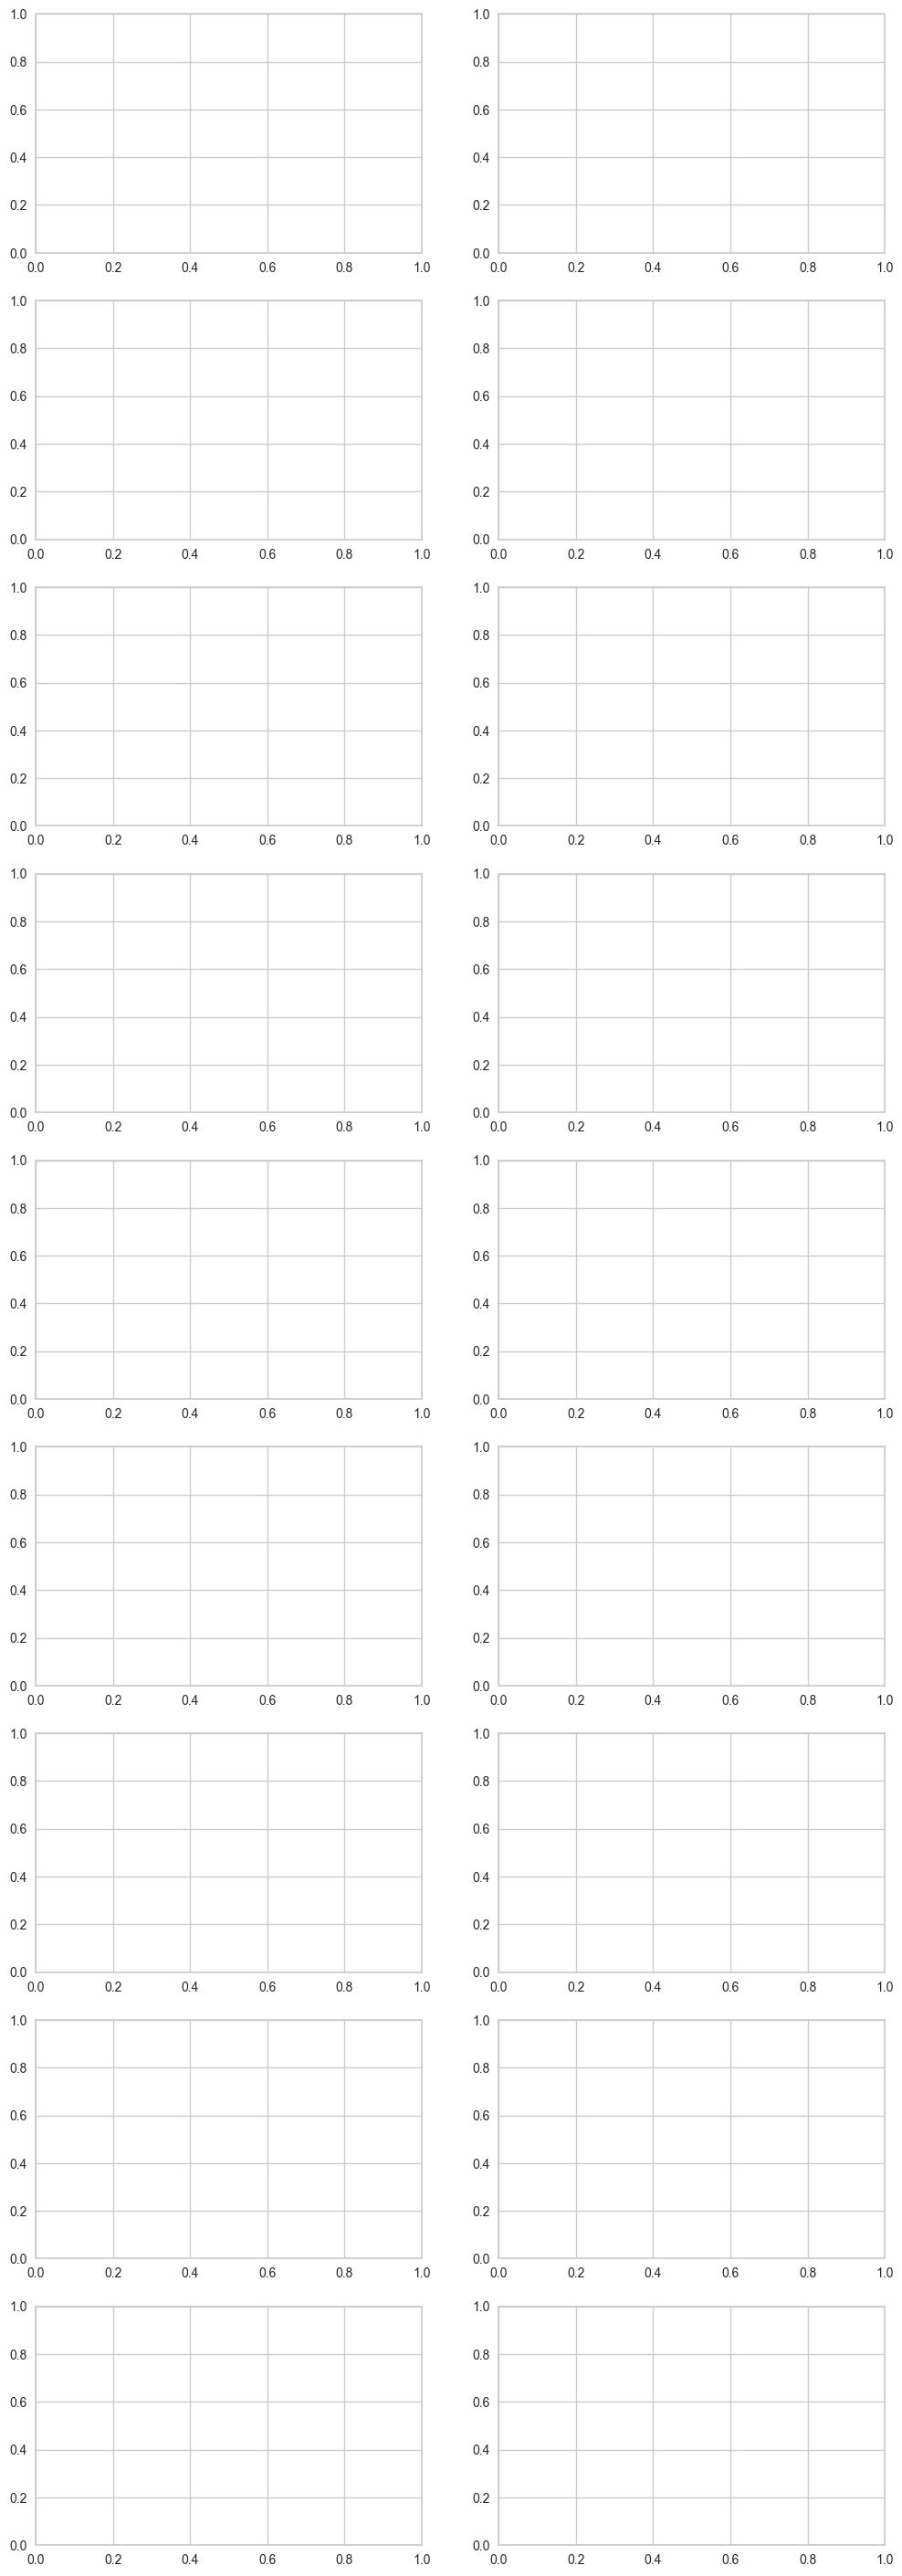

In [141]:
# Plot histograms for numeric columns
num_plots = len(numeric_cols)          # total number of numeric columns
rows = math.ceil(num_plots / 2)        # how many rows of subplots we need
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))  # create a grid of subplots
axes = axes.flatten()                 

for i, col in enumerate(numeric_cols):
    axes[i].hist(data[col].dropna(), bins=30) 
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# If there's an odd number of columns, turn off the unused subplot(s)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Plot bar charts for binary columns
bin_plots = len(binary_cols)
rows = math.ceil(bin_plots / 2)
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    data[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Bar Chart of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Plot bar charts for categorical columns
cat_plots = len(categorical_cols)
rows = math.ceil(cat_plots / 2)
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Bar Chart of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

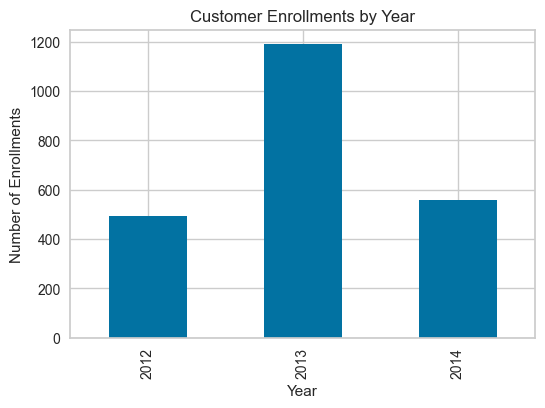

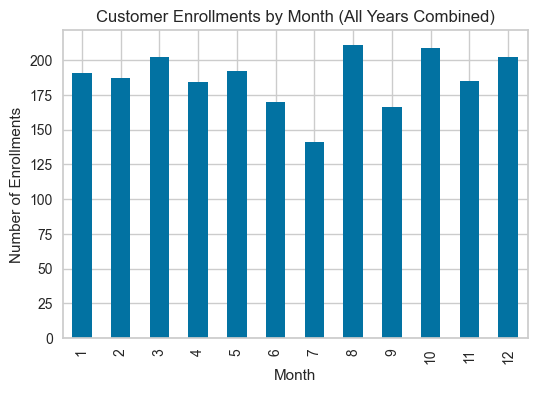

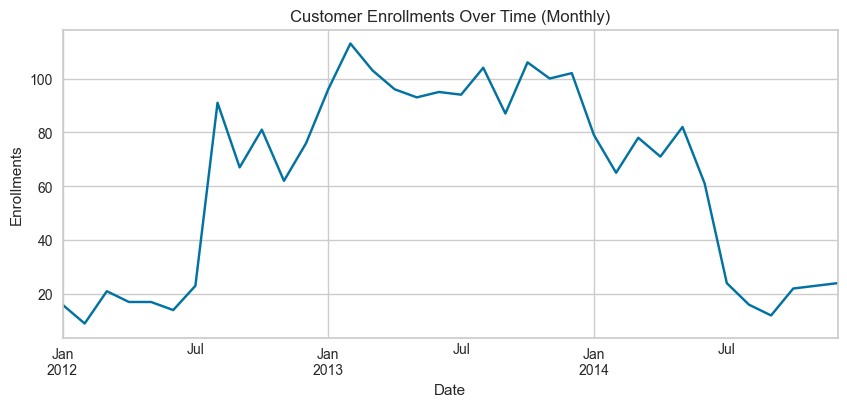

In [111]:
# Count enrollments by year
enrollments_per_year = data['Dt_Customer'].dt.year.value_counts().sort_index()

plt.figure(figsize=(6,4))
enrollments_per_year.plot(kind='bar')
plt.title('Customer Enrollments by Year')
plt.xlabel('Year')
plt.ylabel('Number of Enrollments')
plt.show()

# Count enrollments by month
enrollments_per_month = data['Dt_Customer'].dt.month.value_counts().sort_index()

plt.figure(figsize=(6,4))
enrollments_per_month.plot(kind='bar')
plt.title('Customer Enrollments by Month (All Years Combined)')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.show()


# Resample by month and count how many enrollments occurred each month
data.set_index('Dt_Customer', inplace=True)  # Temporarily make Dt_Customer the index
enrollments_ts = data.resample('M').size()   # Count rows per month

plt.figure(figsize=(10,4))
enrollments_ts.plot()
plt.title('Customer Enrollments Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Enrollments')
plt.show()

data.reset_index(inplace=True)

data.reset_index(inplace=True)


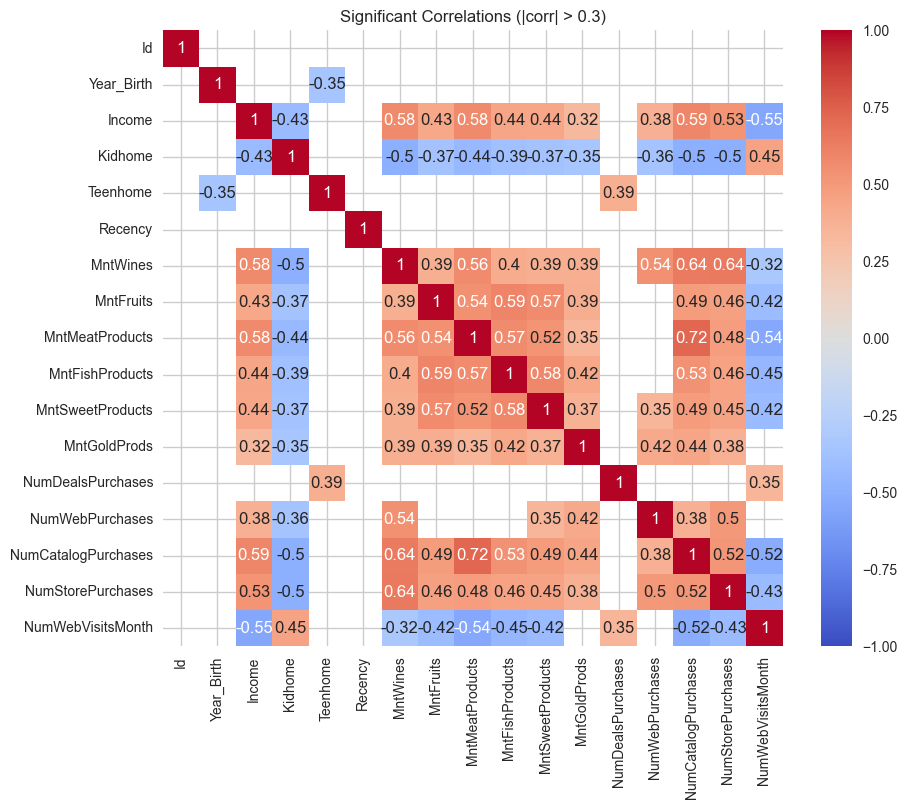

In [112]:
# Correlation heatmap
numeric_data = data[numeric_cols]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Create a boolean mask where values within [-0.3, 0.3] are True
mask = corr_matrix.abs() < 0.3

# Plot heatmap using the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Significant Correlations (|corr| > 0.3)")
plt.show()

In [113]:
# Correlations with the target
numeric_data_with_response = data[numeric_cols + ['Response']]

corr = numeric_data_with_response.corr()["Response"].sort_values()

# Display correlations
print("Top 10 - Positive Correlations:")
print("-----------------------------------")
print(corr.tail(10))
print("\nTop 10 - Negative Correlations:")
print("------------------------------")
print(corr.head(10))

Top 10 - Positive Correlations:
-----------------------------------
MntFishProducts        0.111331
MntSweetProducts       0.117372
MntFruits              0.125289
Income                 0.132867
MntGoldProds           0.139850
NumWebPurchases        0.148730
NumCatalogPurchases    0.220810
MntMeatProducts        0.236335
MntWines               0.247254
Response               1.000000
Name: Response, dtype: float64

Top 10 - Negative Correlations:
------------------------------
Recency             -0.198437
Teenhome            -0.154446
Kidhome             -0.080008
Id                  -0.021968
NumWebVisitsMonth   -0.003987
NumDealsPurchases    0.002238
Year_Birth           0.021325
NumStorePurchases    0.039363
MntFishProducts      0.111331
MntSweetProducts     0.117372
Name: Response, dtype: float64


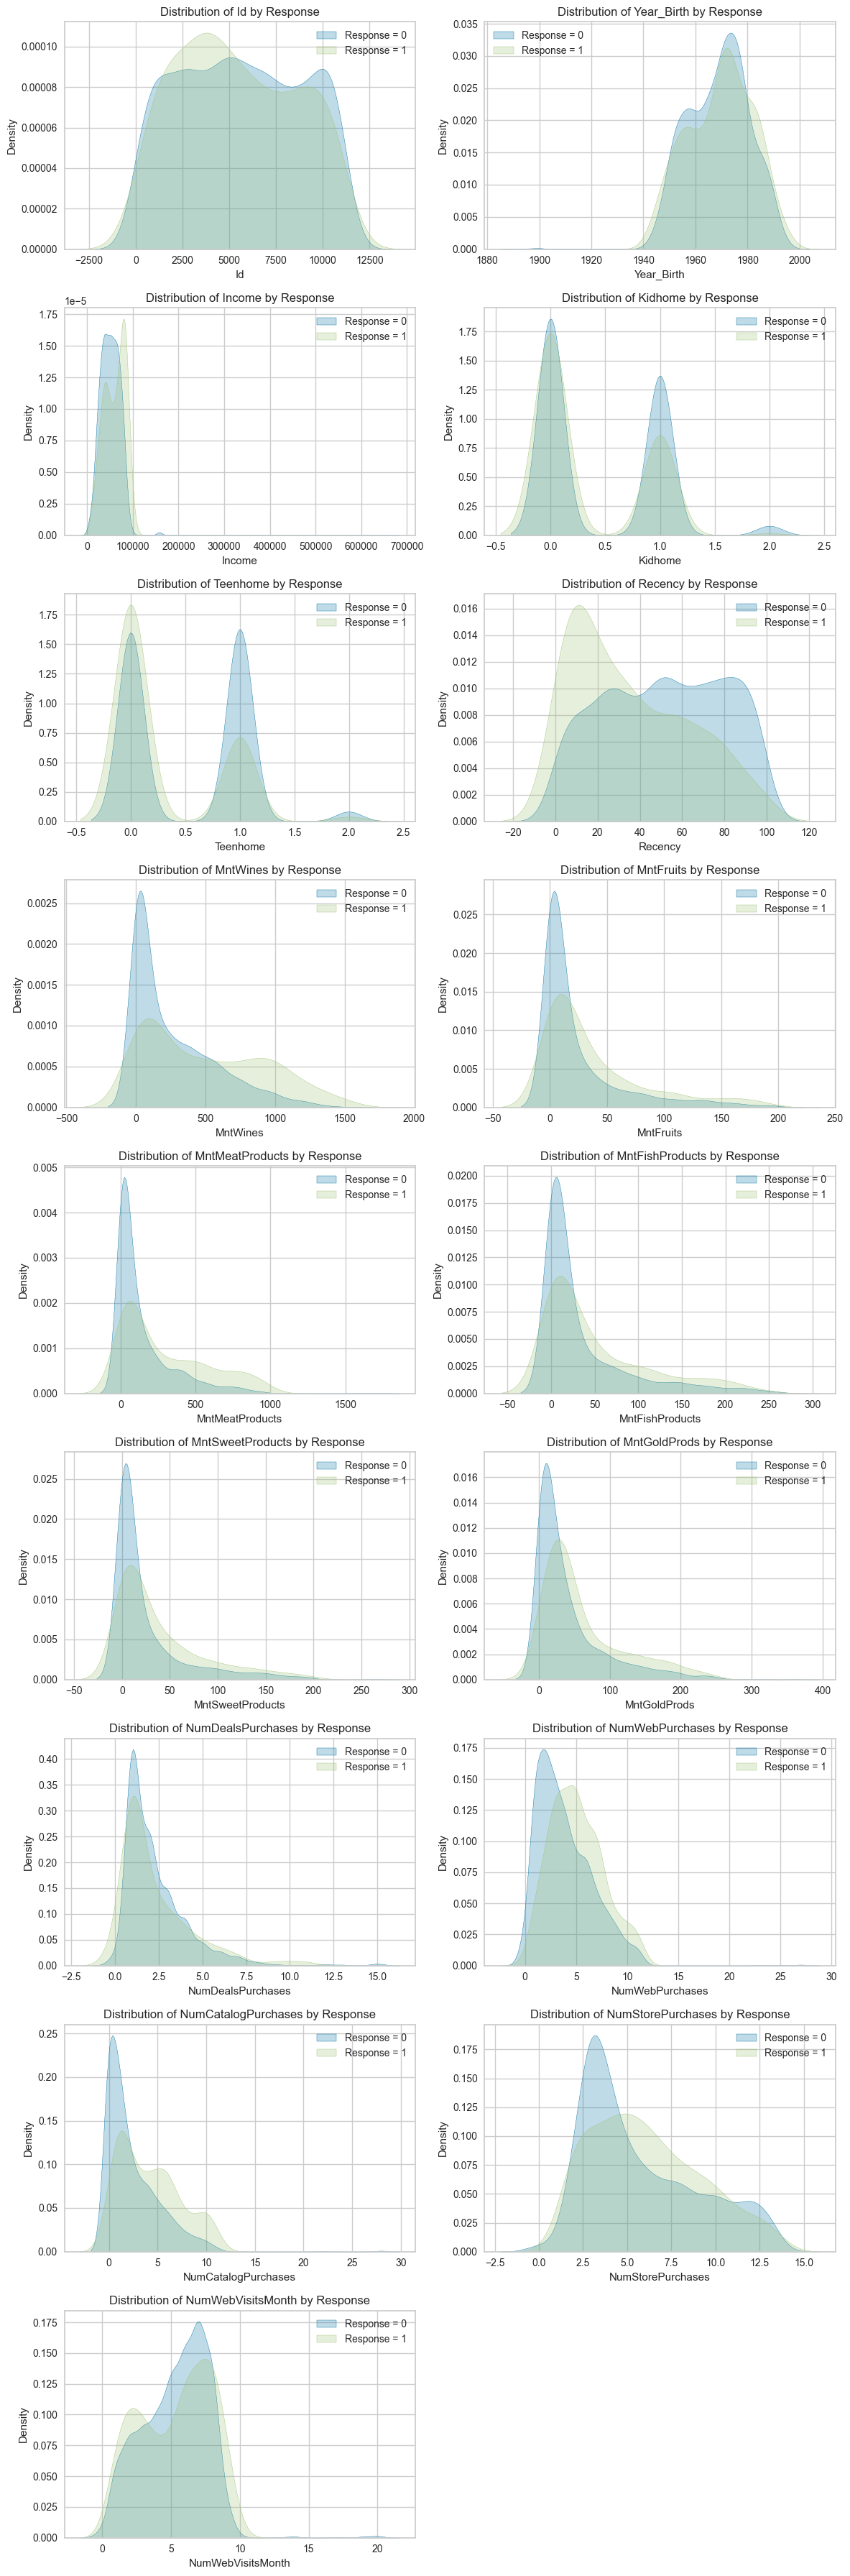

In [114]:
num_plots = len(numeric_cols)          # Total number of numeric columns
rows = math.ceil(num_plots / 2)        # Number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))  # Create a grid of subplots
axes = axes.flatten()                 

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=data[data['Response'] == 0][col], label="Response = 0", fill=True, ax=axes[i])
    sns.kdeplot(data=data[data['Response'] == 1][col], label="Response = 1", fill=True, ax=axes[i])

    axes[i].set_title(f'Distribution of {col} by Response')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# If there's an odd number of columns, turn off the unused subplot(s)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

#### **Feature transformation and creation functions**

In [115]:
############Skewness coeficcient and Log Transformation###############
def identify_and_transform_skewed_features(data, threshold=1.0):
    """
    Identifies skewed numerical features and applies log transformation to them.
    
    Parameters:
        data (pd.DataFrame): Input dataframe
        threshold (float): Skewness threshold above which to apply transformation
    
    Returns:
        pd.DataFrame: Dataframe with transformed features
        list: List of transformed feature names
    """
    # Copy the dataframe to avoid modifying the original
    df_transformed = data.copy()
    
    # Get only numeric columns (exclude binary)
    numeric_cols = [col for col in data.select_dtypes(include=['number']).columns
                   if len(data[col].unique()) > 2]  # Exclude binary columns
    
    # Calculate skewness for each numeric column
    skewness = data[numeric_cols].skew()
    
    # Identify highly skewed features (above threshold)
    highly_skewed = skewness[skewness.abs() > threshold].index.tolist()
    
    print(f"Features with skewness > {threshold}:")
    for col in highly_skewed:
        print(f"{col}: {skewness[col]:.2f}")
    
    # Apply log transformation to highly skewed features
    transformed_features = []
    for feature in highly_skewed:
        # Add small constant to handle zeros
        if (data[feature] >= 0).all():  # Only transform if all values are non-negative
            # For positive skew, use log1p transformation
            if skewness[feature] > 0:
                df_transformed[feature] = np.log1p(df_transformed[feature])
                transformed_features.append(feature)
                print(f"Applied log1p transformation to {feature}")
            # For negative skew, use different approach if needed
            else:
                # Can implement different transformations for negative skew if needed
                pass
    
    # Check skewness after transformation
    if transformed_features:
        print("\nSkewness after transformation:")
        for feature in transformed_features:
            print(f"{feature}: {df_transformed[feature].skew():.2f}")
    
    return df_transformed, transformed_features

In [116]:
##############K-means Clustering for Customer Segmentation###########
def implement_kmeans_segmentation(data, n_clusters=4, random_state=42):
    """
    Implements K-means clustering on customer data and adds cluster labels.
    
    Parameters:
        data (pd.DataFrame): Input dataframe
        n_clusters (int): Number of clusters for K-means
        random_state (int): Random seed for reproducibility
    
    Returns:
        pd.DataFrame: Dataframe with added cluster labels
        KMeans: Fitted K-means model
    """   
    # Select relevant features for clustering
    cluster_features = [
        'income', 'kidhome', 'teenhome', 'recency',
        'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 
        'mntsweetproducts', 'mntgoldprods',
        'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth'
    ]
    
    # Make sure all features exist in the dataframe
    valid_features = [col for col in cluster_features if col in data.columns]
    
    # Extract clustering data
    clustering_data = data[valid_features].copy()
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(clustering_data)
    
    # Determine optimal number of clusters using Elbow Method
    distortions = []
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(scaled_data)
        distortions.append(kmeans.inertia_)
    
    # Plot Elbow Method
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    # Train final K-means model with specified number of clusters
    final_kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = final_kmeans.fit_predict(scaled_data)
    
    # Add cluster labels to the original dataframe
    data_with_clusters = data.copy()
    data_with_clusters['customer_segment'] = clusters
    
    # Analyze clusters
    cluster_analysis = data_with_clusters.groupby('customer_segment').agg({
        'income': 'mean',
        'kidhome': 'mean',
        'teenhome': 'mean',
        'mntwines': 'mean',
        'mntmeatproducts': 'mean',
        'numwebpurchases': 'mean',
        'response': ['mean', 'count']
    })
    
    print("Cluster Analysis:")
    print(cluster_analysis)
    
    return data_with_clusters, final_kmeans

#### **Unique values for the categorical data**

In [117]:
Unique_education = data["Education"].value_counts()
Unique_marital = data["Marital_Status"].value_counts()
print(Unique_education)
print(Unique_marital)

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64


#### **Data cleanup**

In [118]:
# Drop the features that are not useful
data.drop(
    ["Id"], axis=1, inplace=True
)

In [119]:
# Clean column names
def clean_col(name: str) -> str:
    """
    Clean the column name by removing spaces and converting to lowercase.
    """

    return name.strip().lower().replace(" ", "_")

In [120]:
for col in data.columns:
    data.rename(columns={col: clean_col(col)}, inplace=True)

#### **Feature engineering** ####

Identifying and transforming skewed features
Features with skewness > 1.0:
income: 6.80
mntwines: 1.18
mntfruits: 2.10
mntmeatproducts: 2.08
mntfishproducts: 1.92
mntsweetproducts: 2.14
mntgoldprods: 1.89
numdealspurchases: 2.42
numwebpurchases: 1.38
numcatalogpurchases: 1.88
Applied log1p transformation to income
Applied log1p transformation to mntwines
Applied log1p transformation to mntfruits
Applied log1p transformation to mntmeatproducts
Applied log1p transformation to mntfishproducts
Applied log1p transformation to mntsweetproducts
Applied log1p transformation to mntgoldprods
Applied log1p transformation to numdealspurchases
Applied log1p transformation to numwebpurchases
Applied log1p transformation to numcatalogpurchases

Skewness after transformation:
income: -1.18
mntwines: -0.55
mntfruits: 0.08
mntmeatproducts: -0.08
mntfishproducts: -0.05
mntsweetproducts: 0.09
mntgoldprods: -0.34
numdealspurchases: 0.67
numwebpurchases: -0.26
numcatalogpurchases: 0.13
Implementing K-means 

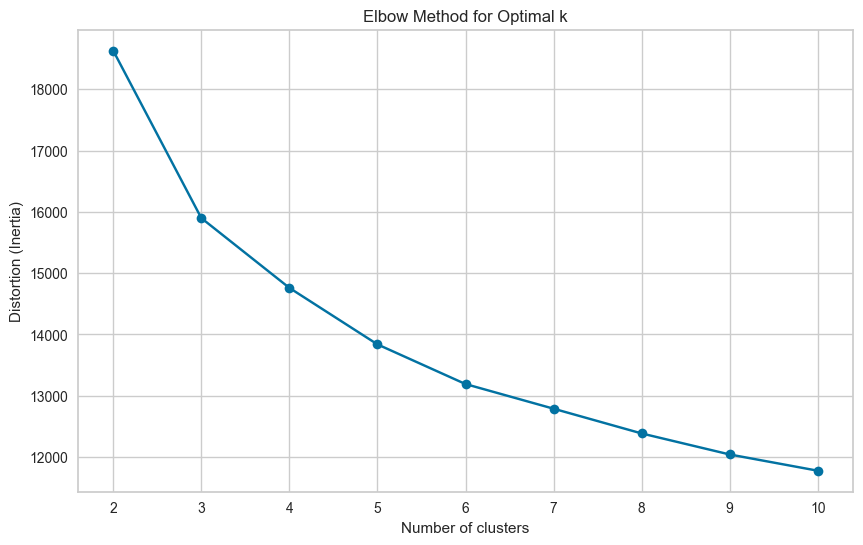

Cluster Analysis:
                     income   kidhome  teenhome  mntwines mntmeatproducts  \
                       mean      mean      mean      mean            mean   
customer_segment                                                            
0                 10.607649  0.840970  0.983827  3.379210        2.479810   
1                 10.868087  0.343696  0.848014  5.593426        4.353213   
2                 10.117619  0.830153  0.047710  2.379022        2.650037   
3                 11.176386  0.063969  0.330287  6.174443        5.763331   

                 numwebpurchases  response        
                            mean      mean count  
customer_segment                                  
0                       0.932066  0.043127   371  
1                       1.842791  0.143351   579  
2                       0.995674  0.116412   524  
3                       1.794853  0.227154   766  


['customer_segmentation_model.pkl']

In [121]:
print("Identifying and transforming skewed features")
data, transformed_features = identify_and_transform_skewed_features(data, threshold=1.0)

print("Implementing K-means clustering for customer segmentation")
data, kmeans_model = implement_kmeans_segmentation(data, n_clusters=4, random_state=42)

joblib.dump(kmeans_model, 'customer_segmentation_model.pkl')

#### **Information leakage**

In [122]:
# We identify a possible data leakage in NumDealsPurchases since the data dictionary is not clear regarding 
# if this purchases refeer to the the offer in the last campagn 
data.drop( ["numdealspurchases"],axis=1,inplace=True,)
data.shape

(2240, 22)

#### **Data preparation**

In [123]:
# Create new columns for year and month directly from Dt_Customer
data['enrollments_year'] = data['dt_customer'].dt.year
data['enrollments_month'] = data['dt_customer'].dt.month
data.drop(['dt_customer'], axis=1, inplace=True)

#### **Categorical encodings**

In [124]:
# First we reclassify some of the labels in our categoricals to rebalance a bit more the data

# Education recategorization
education_mapping = {
    'PhD': 'Post Graduate',
    'Master': 'Post Graduate',
    '2n Cycle': 'Graduate',
    'Graduation': 'Graduate',
    'Basic': 'Pre Graduate'
}

# Apply education mapping
data['education'] = data['education'].map(education_mapping)

# Marital status recategorization
marital_mapping = {
    'Married': 'Married',
    'Together': 'Together',
    'Single': 'Single',
    'Divorced': 'Divorced',
    'Widow': 'Widow',
    'Alone': 'Single',
    'YOLO': 'Single',
    'Absurd': 'Single'
}

# Apply marital status mapping
data['marital_status'] = data['marital_status'].map(marital_mapping)

# Verify the changes
print("\nNew Education Categories:")
print(data['education'].value_counts())

print("\nNew Marital Status Categories:")
print(data['marital_status'].value_counts())


New Education Categories:
education
Graduate         1330
Post Graduate     856
Pre Graduate       54
Name: count, dtype: int64

New Marital Status Categories:
marital_status
Married     864
Together    580
Single      487
Divorced    232
Widow        77
Name: count, dtype: int64


In [ ]:
# We then can one hot encode
data = pd.get_dummies(data)
print(data.shape)
#data.to_excel("data_after.xlsx")


(2240, 29)


#### **Separate features and target**

In [126]:
y = data['response']  # Get target
X = data.drop('response', axis=1)  # Get all other columns as features

In [127]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42
)

#### **Test-validation split**

In [128]:
X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

In [129]:
print(f"Number of validation samples (X_val): {len(X_val)}")
print(f"Number of test samples (X_test): {len(X_test)}")
print(f"Number of validation labels (y_val): {len(y_val)}")
print(f"Number of test labels (y_test): {len(y_test)}")

Number of validation samples (X_val): 336
Number of test samples (X_test): 336
Number of validation labels (y_val): 336
Number of test labels (y_test): 336


#### **Standarize the data**

In [130]:
sc = StandardScaler()
non_segment_cols = [col for col in X.columns if not col.startswith('customer_segment_')]
X_train = sc.fit_transform(X_train[non_segment_cols])
X_val = sc.transform(X_val[non_segment_cols])
X_test = sc.transform(X_test[non_segment_cols])

In [131]:
# Convert nparrays to Dataframes
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df["target"] = y_train.reset_index(drop=True)

val_df = pd.DataFrame(X_val, columns=X.columns)
val_df["target"] = y_val.reset_index(drop=True)

test_df = pd.DataFrame(X_test, columns=X.columns)
test_df["target"] = y_test.reset_index(drop=True)

In [132]:
# Export to parque files
train_df.to_parquet("train.parquet")
val_df.to_parquet("val.parquet")
test_df.to_parquet("test.parquet")

#### **Base line model - Dummy Classifier**

In [133]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [134]:
# Accuracy
accuracy_dummy = dummy_clf.score(X_val, y_val)  # accuracy
# Precission 
precision_dummy =precision_score(y_val, dummy_clf.predict(X_val))
print(accuracy_dummy)
print(precision_dummy)

0.8452380952380952
0.0
